In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
from simpy_helpers import Source, Resource , Stats, Entity
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation
import random

## Port Process Overview

### Arrival at the Port:
- The ship arrives at the port, and the arrival time (`arrival_time`) is recorded.
- The real-world date and time (`real_arrival_time`) is derived from the simulation clock.
- The ship’s type and cargo are identified, and the current size of the berth queues is logged.

### Waiting for Daylight (Night Wait):
- If the ship arrives at night (before 8 AM or after 8 PM), it must wait until 8 AM.
- The wait time until daylight is calculated, and the ship waits for this period.

### Berth Request:
- The ship requests a berth and enters the queue if one is unavailable.
- The function checks meteorological conditions to determine if the ship can proceed.
  
### Meteorological Check (Every 3 Hours):
- Every 3 hours, the meteorological conditions are checked to ensure it's safe for the ship to dock and load.
  
### Waiting Time Calculations:
- Night waiting time (`night_waiting_time`), meteorological check waiting time (`mc_waiting_time`), and berth waiting time (`berth_waiting_time`) are calculated and logged.

### Loading Process:
- **Pre-Service**: Before loading, the ship undergoes a random pre-service wait (`pre_service_time`).
- **Loading**: The ship starts loading once conditions are met. The loading rate is affected by maintenance if it falls within a maintenance period (2/3 of the normal rate).
  - The function simulates loading in time steps (`time_step`), adjusting for weather and storage availability.
  - If forced to depart due to weather, the ship leaves, and a forced departure is logged.
  - If storage is insufficient, the ship waits for a storage refill.
- **Post-Service**: After loading, the ship undergoes a random post-service wait (`post_service_time`).

### Forced Departure:
- If weather conditions deteriorate significantly (forced departure threshold is reached), the ship must leave and wait in the pilot boarding area.
- If the ship is a GPL carrier and sufficiently filled, it may depart without returning to port.

### Departure:
- After loading, the ship releases the berth and departs the port.
- The function logs the entire process, including loading time, waiting time, and total turnaround time (`TAT`), as well as the cargo loaded.
- If a forced departure occurs, it is recorded.

### Maintenance Period:
- During certain periods of the year, one of the three loading arms at the berth undergoes maintenance for 7 random days.
- During maintenance, only two arms are available, and the loading rate is reduced to 2/3 of the normal rate.


In [2]:
def time_to_minutes(time_str):
    """Convert HH:MM time format to total minutes."""
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

def minutes_to_time(minutes):
    """Convert total minutes to HH:MM time format."""
    hours = minutes // 60
    minutes = minutes % 60
    return f"{hours}:{minutes:02}"

def average_time(time_list):
    """Calculate the average time from a list of HH:MM time strings."""
    total_minutes = sum(time_to_minutes(time) for time in time_list)
    average_minutes = total_minutes / len(time_list)
    return minutes_to_time(int(average_minutes))
def max_time(time_list):
    """Calculate the maximum time from a list of HH:MM time strings."""
    max_minutes = max(time_to_minutes(time) for time in time_list)
    return minutes_to_time(int(max_minutes))

def format_time( sim_time):
    hours = int(sim_time)
    minutes = int((sim_time - int(sim_time)) * 60)
    return f"{hours}:{minutes:02}"

def time_date(year , month , day , hour , minute =0):
    current_time = datetime(year, month, day, hour)
    current_time = f"{current_time.year}-{current_time.month:02d}-{current_time.day:02d} {hour}:{minute:02d}"
    return current_time
def get_closest_time(current_time):
    """
    Get the closest time to the current time where the hour is a multiple of 3 and the minutes are zero.
    
    Parameters:
    current_time (datetime): The current time.
    
    Returns:
    datetime: The closest time with hour % 3 == 0 and minutes == 0.
    """
    current_hour = current_time.hour
    next_hour = (current_hour // 3 + 1) * 3 if current_hour % 3 != 0 else current_hour
    if next_hour == 24:
        next_hour = 0
        current_time += timedelta(days=1)
    closest_time = current_time.replace(hour=next_hour, minute=0, second=0, microsecond=0)
    return closest_time
def get_closest_time(current_time):
    """
    Get the closest time to the current time where the hour is a multiple of 3 and the minutes are zero.
    
    Parameters:
    current_time (datetime): The current time.
    
    Returns:
    datetime: The closest time with hour % 3 == 0 and minutes == 0.
    """
    current_hour = current_time.hour
    
    # Calculate the next closest time
    next_hour = (current_hour // 3 + 1) * 3 if current_hour % 3 != 0 else current_hour
    if next_hour == 24:
        next_hour = 0
        next_time = (current_time + timedelta(days=1)).replace(hour=next_hour, minute=0, second=0, microsecond=0)
    else:
        next_time = current_time.replace(hour=next_hour, minute=0, second=0, microsecond=0)
    
    # Calculate the previous closest time
    prev_hour = (current_hour // 3) * 3 if current_hour % 3 != 0 else current_hour - 3
    if prev_hour < 0:
        prev_hour = 21
        prev_time = (current_time - timedelta(days=1)).replace(hour=prev_hour, minute=0, second=0, microsecond=0)
    else:
        prev_time = current_time.replace(hour=prev_hour, minute=0, second=0, microsecond=0)
    
    # Determine which of the two times is closer to the current time
    if abs((current_time - prev_time).total_seconds()) <= abs((next_time - current_time).total_seconds()):
        return prev_time
    else:
        return next_time

In [3]:
Weather = pd.read_excel('Weather_Time_Series.xlsx')
Weather.head()

,Date,Wave direction [deg],Wave height [m],Wave period [s],Wind direction [deg],Wind speed [m/s]
0,2015-01-01 0:00,352,0.22,9.25,11,8.34
1,2015-01-01 3:00,8,0.20,9.32,4,7.51
2,2015-01-01 6:00,337,0.19,10.19,8,6.54
3,2015-01-01 9:00,292,0.19,11.05,8,6.68
4,2015-01-01 12:00,292,0.20,10.86,4,6.31


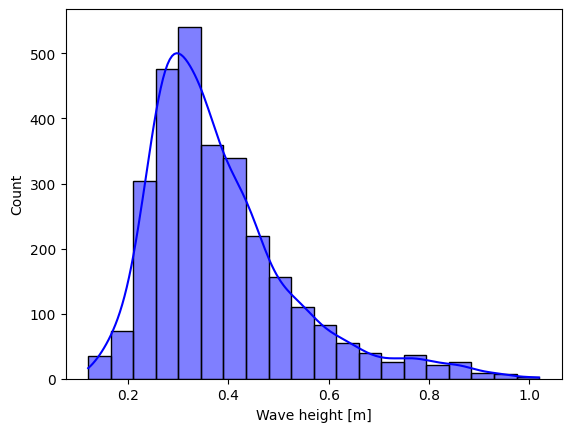

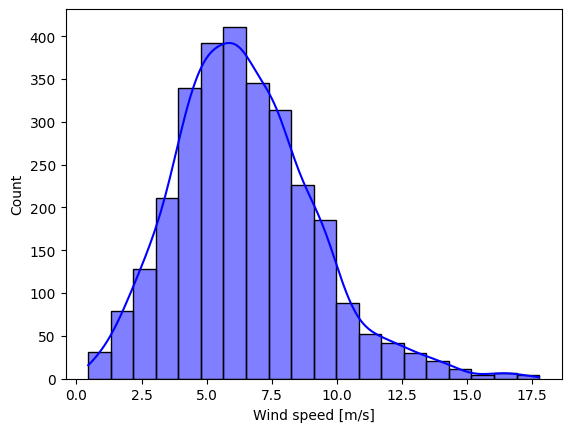

In [4]:

sns.histplot(data=Weather, x='Wave height [m]', color='blue', bins=20, kde=True)
plt.show()

sns.histplot(data=Weather, x='Wind speed [m/s]', color='blue', bins=20, kde=True)
plt.show()

In [5]:
print(Weather.keys())
Weather.describe()

Index(['Date', 'Wave direction [deg]', 'Wave height [m]', 'Wave period [s]',
       'Wind direction [deg]', 'Wind speed [m/s]'],
      dtype='object')


,Wave direction [deg],Wave height [m],Wave period [s],Wind direction [deg],Wind speed [m/s]
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,305.767808,0.382380,11.089812,129.297945,6.485103
std,96.090315,0.143847,2.820716,139.591086,2.670264
min,1.000000,0.120000,4.590000,0.000000,0.450000
25%,322.000000,0.280000,8.850000,16.000000,4.650000
50%,338.000000,0.350000,10.900000,48.000000,6.250000
75%,352.000000,0.440000,13.160000,307.000000,8.045000
max,359.000000,1.020000,20.730000,360.000000,17.780000


In [6]:
class ShipArrivalModel:
    def __init__(self, env, production_data):
        self.env = env
        
        self.production_data = production_data
        self.previous_eta = 0  # Initial ETA for the first ship

    def select_random_ship(self):
        """Randomly select a ship type based on fleet composition probabilities."""
        product = np.random.choice(self.production_data['Product_Type'], p=self.production_data['Composition'])

        if product == 'GPL':
            fleet_composition = self.production_data[self.production_data['Product_Type'] == 'GPL'].loc[0, 'fleet_composition']
            ship_type = np.random.choice(fleet_composition['Ship_Type'], p=fleet_composition['Composition'])
            capacity = fleet_composition.loc[fleet_composition['Ship_Type'] == ship_type, 'Capacity'].values[0]
        else:
            fleet_composition = self.production_data[self.production_data['Product_Type'] == 'Gasoline'].loc[1, 'fleet_composition']
            ship_type = np.random.choice(fleet_composition['Ship_Type'], p=fleet_composition['Composition'])
            capacity = fleet_composition.loc[fleet_composition['Ship_Type'] == ship_type, 'Capacity'].values[0]
        

        return ship_type, capacity , product

    def calculate_iat(self, capacity , days = 366):
        """Calculate the Inter-Arrival Time (IAT) for the ship."""
        production_per_data = self.production_data['proction_per_year'].sum()/days
        iat = capacity / production_per_data
        return iat
    

    

In [63]:
class GenerateShips:
    def __init__(self, env, berths, berth_maintenance, channel, weather_data, start_time, mean_pre_service_time, mean_post_service_time, stats, production_data , storage):
        self.env = env
        self.berths = berths
        self.berth_maintenance = berth_maintenance
        self.weather_data = weather_data
        self.production_data = production_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = channel
        self.storage = storage
        self.ITA = []
        self.ATA = []
        self.ITA_gpl = []
        self.ITA_gasoline = []

    def generate_ships(self):
        
        ship_arrival_model = ShipArrivalModel(self.env, self.production_data)
        for _ in range(1000):
            ship_type, ship_capacity, product = ship_arrival_model.select_random_ship()
            iat = ship_arrival_model.calculate_iat(ship_capacity)
            
            # Append to product-specific lists
            if product == 'GPL':
                self.ITA_gpl.append(iat * 24)
            elif product == 'Gasoline':
                self.ITA_gasoline.append(iat * 24)

        # Calculate initial averages
        avg_gpl = np.mean(self.ITA_gpl)
        avg_gasoline = np.mean(self.ITA_gasoline)
        production_gpl = 0
        production_gasoline = 0
        i = 0
        while True:
            """if production_gpl >= 7000 and production_gasoline >= 3000:
                print('Production Completed')
                break
            elif production_gpl >= 7000:
                self.production_data['Composition'] = [0 , 1]
            elif production_gasoline >= 3000:
                self.production_data['Composition'] = [1 , 0]
            else:
                
                self.production_data['Composition'] = [
                    (7000-production_gpl )/ (10000 - production_gasoline - production_gpl),
                    (3000-production_gasoline) / (10000 - production_gasoline - production_gpl),
                ]"""
                

            ship_type, ship_capacity ,product = ship_arrival_model.select_random_ship()

            if product == 'GPL':
                avg = avg_gpl
            elif product == 'Gasoline':
                avg = avg_gasoline

            #a_ita = np.random.triangular(0.5 * iat, iat, 1.5 * iat
            #avg = sum(self.ITA)/len(self.ITA)
            arrival_time = np.random.exponential(avg)

            rate = np.abs(arrival_time - avg) / avg
            if rate > 0.2:
                arrival_time = avg

            yield self.env.timeout(arrival_time)
            ship = Ship(self.env,ship_type, product , self.berths, self.berth_maintenance, self.channel, self.weather_data, self.start_time, self.mean_pre_service_time, self.mean_post_service_time,self.storage, self.stats)
            i += 1
            #print(i)
            self.env.process(ship.process())
            if product == 'GPL':
                production_gpl = ship.get_production('GPL')
                self.production_data.loc[self.production_data['Product_Type'] == product, 'proction_per_year'] -= production_gpl
            else:
                production_gasoline = ship.get_production('Gasoline')
                self.production_data.loc[self.production_data['Product_Type'] == product, 'proction_per_year'] -= production_gasoline

            ship_arrival_model = ShipArrivalModel(self.env, self.production_data)
            #print(366 - (self.env.now / 24))
            
            if (self.env.now >= 183 * 24 and self.env.now <= 183 * 24 +5) or (self.env.now >= 90 * 24 and self.env.now <= 90 * 24 +5) :
                for _ in range(100):        
                    ship_type, ship_capacity, product = ship_arrival_model.select_random_ship()
                    iat = ship_arrival_model.calculate_iat(ship_capacity, (366 - (self.env.now / 24)))
            
                    # Append to product-specific lists
                    if product == 'GPL':
                        self.ITA_gpl.append(iat * 24)
                    elif product == 'Gasoline':
                        self.ITA_gasoline.append(iat * 24)
            
            avg_gpl = np.mean(self.ITA_gpl)
            avg_gasoline = np.mean(self.ITA_gasoline)
            self.ATA.append(arrival_time)
        
    def get_ita(self):
        return self.ITA
    
    def get_ata(self):
        return self.ATA

In [8]:
class Berth:
    def __init__(self, env):
        self.env = env
        self.maintenance_start_date = self.generate_maintenance_date()
        self.maintenance_duration = timedelta(days=7)

    def generate_maintenance_date(self):
        """Generates a random 7-day maintenance window within the year."""
        year_start = datetime(2025, 1, 1)
        year_end = datetime(2025, 12, 31)
        # Randomly select a start date within the year, leaving room for a 7-day window
        random_day = random.randint(0, (year_end - year_start).days - 7)
        return year_start + timedelta(days=random_day)

    def is_maintenance_period(self, current_time):
        """Check if the current time is within the maintenance period."""
        maintenance_end = self.maintenance_start_date + self.maintenance_duration
        return self.maintenance_start_date <= current_time <= maintenance_end

In [9]:
class Storage:
    def __init__(self, env,loaded_amount = 0, initial_storage=80000):
        self.env = env
        self.storage = initial_storage  # Shared storage for the port
        self.loaded_amount = loaded_amount

    def decrease_storage(self, amount):
        """Decrease the storage by a certain amount."""
        if self.storage >= amount:
            self.storage -= amount
            self.loaded_amount += amount
            return True , self.loaded_amount , 1
        elif self.storage <= amount*0.95 :
            percentage = self.storage/amount
            self.loaded_amount += self.storage
            self.storage = 0
            return False , self.loaded_amount , percentage
            
        else:
            #self.loaded_amount += self.storage
            print(amount , self.storage)
            self.storage = 0
            

            return False , self.loaded_amount ,0


    def refill_storage(self):
        """Simulate refilling the storage."""

        yield self.env.timeout(24)
        self.storage = 80000  # Reset to full capacity

In [10]:

class Stats:
    def __init__(self):
        self.total_times = []
        self.berth_waiting_times = []
        self.mc_waiting_times = []
        self.processing_times = []
        self.night_waiting_times = []
        self.waiting_times = []
        self.queue_sizes = {"berth_type1": [], "berth_type2": [], "berth": []}
        self.ship_data = []
        self.forced_departures = 0
        self.cargo_volume = {"exported": 0, "imported": 0}

    def add_total_time(self, time):
        self.total_times.append(time)

    def add_berth_waiting_time(self, time):
        self.berth_waiting_times.append(time)

    def add_mc_waiting_time(self, time):
        self.mc_waiting_times.append(time)

    def add_processing_time(self, time):
        self.processing_times.append(time)

    def add_night_waiting_time(self, time):
        self.night_waiting_times.append(time)

    def add_waiting_time(self, time):
        self.waiting_times.append(time)

    def add_queue_size(self, queue_type, size):
        self.queue_sizes[queue_type].append(size)

    def add_ship_data(self, arrival, vessel_ID, vessel, Product_type, Berth_claimed, Finished_loading, Berth_released, wt_meteorological_constraints, wt_ships_in_queue, wt_berth_occupied, wt_night, processing_time,berth_occupied, tat, expected_tat, departure_time, cargo_loaded):
        self.ship_data.append({
            "Arrival": arrival,
            "vessel_id": vessel_ID,
            "Vessel": vessel,
            "Product_type": Product_type,
            "Berth_claimed": Berth_claimed,
            "Finished_loading": Finished_loading,
            "Berth_released": Berth_released,
            "WT meteorological constraints": wt_meteorological_constraints,
            "WT Ships in queue": wt_ships_in_queue,
            "WT Berth occupied": wt_berth_occupied,
            "WT Night": wt_night,
            "Port Operation": processing_time,
            "berth occupied": berth_occupied,
            "TAT": tat,
            "Expected TAT": expected_tat,
            "Departure_Time": departure_time,
            "cargo_loaded": cargo_loaded
        })

    def increment_forced_departures(self):
        self.forced_departures += 1

    def add_cargo_volume(self, volume, direction):
        if direction == "exported":
            self.cargo_volume["exported"] += volume
        elif direction == "imported":
            self.cargo_volume["imported"] += volume

    def get_max_kpis(self):
        max_berth_waiting_time = max_time(self.berth_waiting_times)
        max_mc_waiting_time = max_time(self.mc_waiting_times)
        max_waiting_time = max_time(self.waiting_times)
        max_processing_time = max_time(self.processing_times)
        max_total_time = max_time(self.total_times)
        return {
            "max_berth_waiting_time": max_berth_waiting_time,
            "max_mc_waiting_time": max_mc_waiting_time,
            "max_waiting_time": max_waiting_time,
            "max_Port Operation": max_processing_time,
            "max_total_time": max_total_time
        }

    def get_average_kpis(self):
        avg_berth_waiting_time = average_time(self.berth_waiting_times)
        avg_mc_waiting_time = average_time(self.mc_waiting_times)
        avg_waiting_time = average_time(self.waiting_times)
        avg_processing_time = average_time(self.processing_times)
        avg_total_time = average_time(self.total_times)
        return {
            "avg_berth_waiting_time": avg_berth_waiting_time,
            "avg_mc_waiting_time": avg_mc_waiting_time,
            "avg_waiting_time": avg_waiting_time,
            "avg_Port Operation": avg_processing_time,
            "avg_total_time": avg_total_time
        }

    def get_ship_type_kpis(self):
        ship_type_data = {}
        for data in self.ship_data:
            ship_type = data["Vessel"]
            if ship_type not in ship_type_data:
                ship_type_data[ship_type] = {
                    "berth_waiting_times": [],
                    "mc_waiting_times": [],
                    "waiting_times": [],
                    "Port Operation": [],
                    "total_times": []
                }
            ship_type_data[ship_type]["berth_waiting_times"].append(data["WT Berth occupied"])
            ship_type_data[ship_type]["mc_waiting_times"].append(data["WT meteorological constraints"])
            ship_type_data[ship_type]["waiting_times"].append(data["WT Ships in queue"])
            ship_type_data[ship_type]["Port Operation"].append(data["Port Operation"])
            ship_type_data[ship_type]["total_times"].append(data["TAT"])

        ship_type_kpis = {}
        for ship_type, times in ship_type_data.items():
            ship_type_kpis[ship_type] = {
                "avg_berth_waiting_time": average_time(times["berth_waiting_times"]),
                "avg_mc_waiting_time": average_time(times["mc_waiting_times"]),
                "avg_waiting_time": average_time(times["waiting_times"]),
                "avg_Port Operation": average_time(times["Port Operation"]),
                "avg_total_time": average_time(times["total_times"]),
                "max_berth_waiting_time": max_time(times["berth_waiting_times"]),
                "max_mc_waiting_time": max_time(times["mc_waiting_times"]),
                "max_waiting_time": max_time(times["waiting_times"]),
                "max_Port Operation": max_time(times["Port Operation"]),
                "max_total_time": max_time(times["total_times"])
            }
        return ship_type_kpis

    def get_queue_sizes(self):
        return self.queue_sizes

    def get_forced_departures(self):
        return self.forced_departures

    def get_cargo_volume(self):
        return self.cargo_volume

    def get_total_ships_by_type(self):
        ship_type_counts = {}
        for data in self.ship_data:
            ship_type = data["Vessel"]
            if ship_type not in ship_type_counts:
                ship_type_counts[ship_type] = 0
            ship_type_counts[ship_type] += 1
        return ship_type_counts


class Ship:
    def __init__(self, env,ship_type,product , berths ,berth_maintenance,chanel, weather_data,start_time, mean_pre_service_time, mean_post_service_time, storage , stats):
        self.env = env
        self.berths = berths
        self.berth_c = berth_maintenance
        self.weather_data = weather_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = chanel
        self.ship_type = ship_type
        self.storage = storage
        self.product = product

    def ship_type0(self, ship_type=None):
        # Define the ship_types dictionary
        ship_types = {
            'category': ['A', 'B', 'C', 'D' , 'E'],
            'Cargaison': [15000, 25000, 35000, 50000 , 80000],
            'Composition': [0.2, 0.2, 0.2, 0.2,0.2],
            "Taux de chargement (T/h)": [1200, 1500, 1800, 2200 , 2400],
            "LOA (m)": [144, 180, 196, 255, 300]
        }

        # Convert the dictionary to a DataFrame
        df_ship_types = pd.DataFrame(ship_types)

        # Set the 'category' column as the index
        df_ship_types.set_index('category', inplace=True)
        if ship_type is None:
            ship_type = np.random.choice(["A", "B", "C", "D","E"], p=df_ship_types["Composition"])
        
        return ship_type,df_ship_types.loc[ship_type]

    def Meterological_accessibility(self, ship_type, current_time):
        
        # Extract weather data
        time_data  = Weather.loc[Weather['Date'] == current_time].iloc[-1]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 2, "wind_speed": 10},
            "B": {"wave_height": 2, "wind_speed": 10},
            "C": {"wave_height": 2, "wind_speed": 10},
            "D": {"wave_height": 2, "wind_speed": 10},
            "E": {"wave_height": 2, "wind_speed": 10}
        }
        

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]']< limits[ship_type]["wave_height"]
                    and time_data['Wind speed [m/s]']< limits[ship_type]["wind_speed"])
        
        return False     
    
    def loading_condition_met(self, ship_type, current_time):
        # Extract weather data
        time_data = Weather.loc[Weather['Date'] == current_time].iloc[-1]
        
        # Define limits for ship types
        limits = {
            "A": {"wave_height": 1.5, "wind_speed": 22},
            "B": {"wave_height": 1.5, "wind_speed": 22},
            "C": {"wave_height": 1.5, "wind_speed": 22},
            "D": {"wave_height": 2, "wind_speed": 22},
            "E": {"wave_height": 2, "wind_speed": 22}
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]'] < limits[ship_type]["wave_height"]
                    and time_data['Wind speed [m/s]'] < limits[ship_type]["wind_speed"])  
        return False
    
    def forced_departure(self, ship_type, current_time):
        # Extract weather data
        time_data = Weather.loc[Weather['Date'] == current_time].iloc[-1]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 2, "wind_speed": 25},
            "B": {"wave_height": 2, "wind_speed": 25},
            "C": {"wave_height": 2, "wind_speed": 25},
            "D": {"wave_height": 2, "wind_speed": 25}
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]'] > limits[ship_type]["wave_height"]
                    or time_data['Wind speed [m/s]'] > limits[ship_type]["wind_speed"])
        return False
  
    def filling_rate(self, time_spent_loading, ship_type_data):
        return ship_type_data["Taux de chargement (T/h)"] * time_spent_loading
        
    def wait_for_better_weather(self, env , start_time , ship_type ):

        current_time = (start_time + timedelta(hours=env.now)).replace(year=2025)
        closest_time = get_closest_time(current_time)
        closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)

        while not self.Meterological_accessibility(ship_type, str(closest_time)):
            current_time = (start_time + timedelta(hours=env.now)).replace(year=2025)
            closest_time = get_closest_time(current_time)
            closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)
            #print(f"waiting for better weather conditions at {closest_time}")
            yield env.timeout(1.5)  # Check every 3 hours
        
    def loading_time(self, ship_type_data):
        
        return ship_type_data["Cargaison"]/ship_type_data["Taux de chargement (T/h)"] 
        
    def request_channel(self , priority):
        with self.channel.request(priority) as channel_req:
            yield channel_req
            time_for_entering = np.random.exponential(1.5)
            yield self.env.timeout(time_for_entering)
            self.channel.release(channel_req)

    def record_time(self ,env, start_time):

        time = env.now - start_time
        formatted_time = format_time(time)
        return formatted_time
       
    def process(self):
        
        avilaible_berth = [i for i,berth in enumerate(self.berths) if berth.count == 0]
        queue_sizes = [len(berth.queue) for berth in self.berths]
        i = np.random.choice(avilaible_berth) if len(avilaible_berth) > 0 else np.argmin(queue_sizes)
        berth = self.berths[i]
        # Record the arrival time
        arrival_time = self.env.now
        real_arrival_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
        real_arrival_time = datetime(real_arrival_time.year ,real_arrival_time.month, real_arrival_time.day, real_arrival_time.hour, real_arrival_time.minute)
        

        # Generate ship data
        Product_type = self.product
        ship_type,ship_data = self.ship_type0(self.ship_type)
        queue_sizes = [len(berth.queue) for berth in self.berths]
        self.stats.add_queue_size("berth_type1", sum(queue_sizes))
        vessel_id = "Vessel"+ ship_type +str(np.random.randint(0,1000))
        #self.stats.add_queue_size("berth_type2", len(self.berth_type2.queue))
        #self.stats.add_queue_size("berth", len(self.berth_type1.queue) + len(self.berth_type2.queue))
        
        
        # Check if the ship arrives during the night
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour
    
        if current_hour >= 20 or current_hour < 8:
            # Calculate the time until 8 AM the next day
            hours_until_8am = (8 - current_hour) % 24
            yield self.env.timeout(hours_until_8am)
        
        # Record night waiting time
        night_waiting_time = format_time(self.env.now - arrival_time)
        self.stats.add_night_waiting_time(night_waiting_time)

        loaded_amount = 0

        if loaded_amount/1000 > 10000:
            print(loaded_amount)
         

         
        
        with berth.request() as req:
            arrival_time = self.env.now
            req.ship_name = vessel_id
            # Request the berth
            yield req

            mc_waiting_start = self.env.now
            # Check if the ship can enter the port
            yield from self.wait_for_better_weather(self.env , self.start_time , ship_type)

            # Record meter
            mc_waiting_time = self.env.now - mc_waiting_start
            mc_waiting_time_r = self.record_time(self.env ,mc_waiting_start )
            self.stats.add_mc_waiting_time(mc_waiting_time_r)

            # Record berth waiting time
            berth_waiting_time = self.env.now - arrival_time - mc_waiting_time
            berth_waiting_time = format_time(berth_waiting_time)
            self.stats.add_berth_waiting_time(berth_waiting_time)

            # Record waiting time
            waiting_time = self.env.now - arrival_time
            waiting_time = format_time(waiting_time)
            self.stats.add_waiting_time(waiting_time)

            # Claim the berth
            berth_claimed = (real_arrival_time + timedelta(hours=self.env.now))
            berth_claimed = datetime(berth_claimed.year ,berth_claimed.month, berth_claimed.day, berth_claimed.hour, berth_claimed.minute)

            # Request channel
            yield from self.request_channel(priority=1)
              
            # Processing time
            start_processing_time = self.env.now
            coef = ship_data["Cargaison"]/(13000 + 25000 + 35000+ 50000 + 80000)
    
            pre_service_time = np.random.exponential(self.mean_pre_service_time)*(1 + coef*0)
            post_service_time =  np.random.exponential(self.mean_post_service_time)*(1 + coef*0)

            # Processing time
            start_processing_time = self.env.now

            yield self.env.timeout(pre_service_time)
            
            current_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)

            if self.berth_c.is_maintenance_period(current_time):   
                loading_rate_factor = 2/3
            else:
                loading_rate_factor = 1

            loading_time = self.loading_time(ship_data) * (1/loading_rate_factor)
            time_now = self.env.now
            time_step = loading_time/20
            load = 0
            added_time = 0
            while self.env.now < time_now + loading_time + added_time and load < ship_data["Cargaison"]:
                
                current_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
                closest_time = get_closest_time(current_time)
                closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)

                if self.loading_condition_met(ship_type, str(closest_time)): 
                    yield self.env.timeout(time_step)
                    amount_to_load = self.filling_rate(time_step, ship_data) * loading_rate_factor
                    load += amount_to_load
                    #print(f"amount to load {amount_to_load}, load_per_ship {load} , vessel_id {vessel_id} , ship_capacity {ship_data['Cargaison']} ")
                    Tr , loaded_amount ,_ = self.storage.decrease_storage(amount_to_load)
                    
                    percentage = (load / ship_data["Cargaison"] )* 100
                    if (not Tr) :
                        # Refill the storage
                        yield self.env.process(self.storage.refill_storage()) 
                        added_time += 24
                        yield self.env.timeout(time_step) 
                        Tr , loaded_amount ,_= self.storage.decrease_storage(amount_to_load)
                        load += amount_to_load
                        percentage = (load / ship_data["Cargaison"] )* 100
                    
                elif self.forced_departure(ship_type, str(closest_time)) :
                    self.stats.increment_forced_departures()
                    if percentage > 0.95:
                        break
                    else:
                        return
                         
                else:
                    print(f"vessel_id {vessel_id} needs to wait for better weather conditions")
                    yield self.env.timeout(2)
                    added_time += 2
            
            cargo_loaded = (ship_data["Cargaison"]*(percentage/100))/1000

            if loaded_amount/1000 > 10000:
                print(loaded_amount)
            # Record finish loading time
            m = self.env.now
            finish_loading = (real_arrival_time + timedelta(hours=self.env.now))
            finish_loading = datetime(finish_loading.year ,finish_loading.month, finish_loading.day, finish_loading.hour, finish_loading.minute)
            
            
            # Record processing time
            processing_time0 = self.env.now - start_processing_time
            processing_time = format_time(processing_time0)
            self.stats.add_processing_time(processing_time)
            yield self.env.timeout(post_service_time)
            
            # Request channel
            yield from self.request_channel(priority=0)

            # Record total time in system (TAT)
            total_time = self.env.now - arrival_time
            total_time = format_time(total_time)
            self.stats.add_total_time(total_time)

            #Release the berth and record the time
            berth.release(req)
            berth_release = (real_arrival_time + timedelta(hours=self.env.now))
            berth_release = datetime(berth_release.year , berth_release.month, berth_release.day, berth_release.hour, berth_release.minute)
            
            # Calculate the expected TAT and departure time
            departure_time = self.start_time + timedelta(hours=self.env.now)
            departure_time = datetime(departure_time.year , departure_time.month, departure_time.day, departure_time.hour, departure_time.minute)
            expected_tat = loading_time + pre_service_time + post_service_time
            
            expected_tat = format_time(expected_tat)
            self.stats.add_ship_data(
                real_arrival_time,
                vessel_id,  # Example vessel ID
                ship_type,
                Product_type, 
                berth_claimed,
                finish_loading,
                berth_release,
                mc_waiting_time_r,
                waiting_time,
                berth_waiting_time,
                night_waiting_time,
                processing_time,
                i,
                total_time,
                expected_tat,
                departure_time.replace(year=2025),
                cargo_loaded
            )

    def get_production(self, product):
        loaded_amount = sum(ship['cargo_loaded'] for ship in self.stats.ship_data if ship['Product_type'] == product)
        return loaded_amount




In [ ]:
np.random.seed(25)

# Parameters
mean_pre_service_time = 4  # Average pre-service time in minutes
mean_post_service_time = 4  # Average post-service time in minutes

simulation_time = 24*366 # Simulate for n days
start_time = datetime.strptime("00:00:00", "%H:%M:%S")
capacity = 2
# Create the SimPy environment
env = simpy.Environment()
berths= [simpy.Resource(env, capacity=1) for _ in range(capacity)]  # Define the mooring station resources
channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource
storage = Storage(env)  # Define the port storage
berth_maintenance = Berth(env)
stats = Stats()

fleet_composition1 = pd.DataFrame({
    'Ship_Type': ['A', 'B', 'C', 'D' , 'E'],
    'Capacity': [15000, 25000, 35000, 50000 , 80000],
    'Composition': [0 , 0.4 ,0.5 , 0.1 ,0],
    "Taux de chargement (T/h)": [1200, 1500, 1800, 2200 , 2400],
    "LOA (m)": [144, 180, 196, 255, 300]
})

fleet_composition2 = pd.DataFrame({
    'Ship_Type': ['A', 'B'],
    'Capacity': [15000, 25000],
    'Composition': [0.4 ,0.6],
    "Taux de chargement (T/h)": [1200, 1500],
    "LOA (m)": [144, 180]
})

production_data = pd.DataFrame({
    'Product_Type': ['GPL', 'Gasoline'],
    'Composition': [1, 0],
    'proction_per_year': [7_500_000, 0],
    'fleet_composition': [fleet_composition1 , fleet_composition2]
})

# Create the ShipArrivalModel instance
ship_arrival_model = ShipArrivalModel(env, production_data )

# Create the ship generator
source = GenerateShips(env, berths,berth_maintenance, channel, Weather,start_time, mean_pre_service_time, mean_post_service_time, stats ,production_data, storage)


# Start the ship generation process
env.process(source.generate_ships())

# Run the simulation
env.run(until=simulation_time)


In [162]:
ATA = source.get_ata()

print(f"Average Inter-Arrival Time: {sum(ATA)/len(ATA):} hours")
ATA = pd.DataFrame(ATA, columns=["Arrival Time"])
ATA.describe()

Average Inter-Arrival Time: 38.06425562485701 hours


,Arrival Time
count,230.000000
mean,38.064256
std,1.810530
min,31.336648
25%,37.337484
50%,37.337484
75%,39.018528
max,46.220598


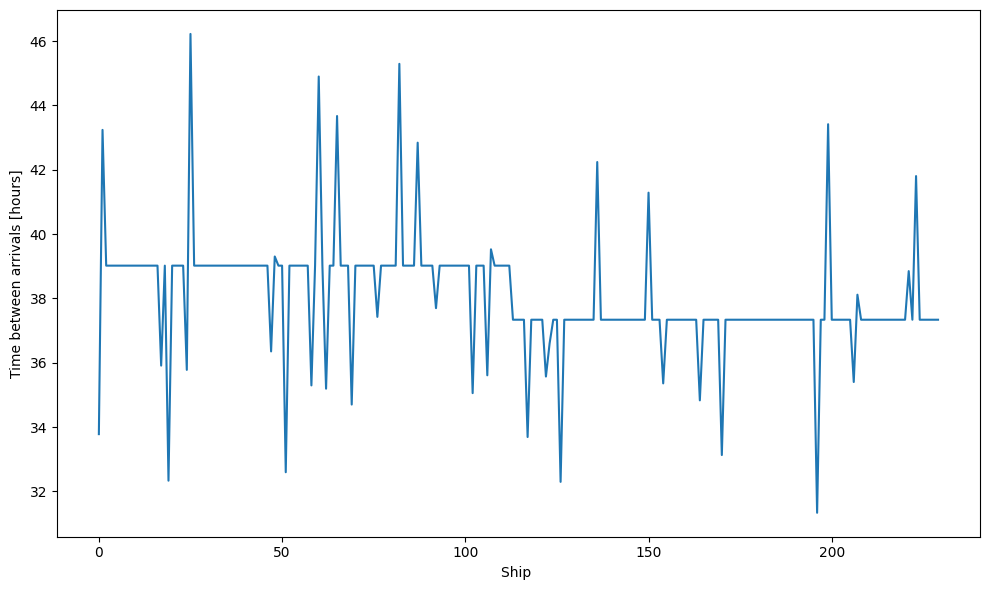

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.plot(range(len(ATA)), ATA)
plt.ylabel('Time between arrivals [hours]')
plt.xlabel('Ship ')

plt.tight_layout()
plt.show()

In [164]:
AVG_Stats = stats.get_average_kpis()
AVG_Stats = pd.DataFrame(AVG_Stats.items(), columns=['KPI', 'Value'])
AVG_Stats


,KPI,Value
0,avg_berth_waiting_time,1:25
1,avg_mc_waiting_time,2:09
2,avg_waiting_time,3:35
3,avg_Port Operation,36:03
4,avg_total_time,46:41


In [165]:
MAX_Stats = stats.get_max_kpis()
MAX_Stats = pd.DataFrame(MAX_Stats.items(), columns=['KPI', 'Value'])
MAX_Stats

,KPI,Value
0,max_berth_waiting_time,53:55
1,max_mc_waiting_time,70:30
2,max_waiting_time,73:37
3,max_Port Operation,71:38
4,max_total_time,130:30


In [166]:
ships= stats.get_ship_type_kpis()
ships_kpis_bytype = pd.DataFrame(ships)
ships_kpis_bytype

,D,B,C
avg_berth_waiting_time,1:45,0:48,1:28
avg_mc_waiting_time,2:42,1:53,2:20
avg_waiting_time,4:28,2:42,3:48
avg_Port Operation,42:42,32:08,38:22
avg_total_time,55:05,41:55,49:26
max_berth_waiting_time,25:59,29:16,53:55
max_mc_waiting_time,55:30,67:30,70:30
max_waiting_time,55:30,73:37,70:30
max_Port Operation,55:59,66:23,71:38
max_total_time,111:25,122:28,130:30


In [167]:
data = stats.ship_data
print(len(data))
data = pd.DataFrame(data)
data.tail()

228


,Arrival,vessel_id,Vessel,Product_type,Berth_claimed,Finished_loading,Berth_released,WT meteorological constraints,WT Ships in queue,WT Berth occupied,WT Night,Port Operation,berth occupied,TAT,Expected TAT,Departure_Time,cargo_loaded
223,2025-12-22 10:45:00,VesselB817,B,GPL,2026-12-14 02:46:00,2026-12-14 23:25:00,2026-12-15 00:57:00,0:00,29:16,29:16,0:00,17:16,0,51:27,17:57,2025-12-24 14:12:00,25.0
224,2025-12-24 00:05:00,VesselB123,B,GPL,2026-12-19 09:47:00,2026-12-21 09:41:00,2026-12-21 10:38:00,67:30,73:37,6:07,8:00,44:12,0,122:28,21:02,2025-12-29 10:33:00,25.0
225,2025-12-25 13:25:00,VesselB252,B,GPL,2026-12-20 23:50:00,2026-12-23 00:13:00,2026-12-23 00:49:00,45:00,45:00,0:00,0:00,44:26,1,93:58,20:38,2025-12-29 11:24:00,25.0
226,2025-12-27 02:45:00,VesselC14,C,GPL,2026-12-25 02:48:00,2026-12-27 02:10:00,2026-12-27 04:43:00,13:30,63:17,49:47,6:00,45:41,0,113:12,22:45,2025-01-01 01:58:00,35.0
227,2025-12-28 16:06:00,VesselB811,B,GPL,2026-12-26 17:00:00,2026-12-28 20:03:00,2026-12-28 20:49:00,13:30,32:48,19:18,0:00,48:15,1,84:37,25:00,2025-01-01 04:43:00,25.0


In [168]:
Gasoline = data[data['Product_type'] == 'Gasoline']
#Gasoline[Gasoline['Vessel'] == 'B'].shape



In [178]:
print(f"loaded amount of product {data['cargo_loaded'].sum()}")
#print(data[data['Product_type'] == 'Gasoline']['cargo_loaded'].sum())
#print(data[data['Product_type'] == 'GPL']['cargo_loaded'].sum())

loaded amount of product 7441.0


In [170]:
occupation_rate = []
for c in range(capacity):
    c_rate = (data[data['berth occupied'] == c]['Port Operation'].apply(time_to_minutes).sum() / (60 * 24)) / 366
    occupation_rate.append(c_rate)


occupation_rate_df = pd.DataFrame({
    'Berth Occupation': range(capacity),
    'Occupation Rate': occupation_rate
})

occupation_rate_df

,Berth Occupation,Occupation Rate
0,0,0.495222
1,1,0.440631


In [ ]:
#data.to_csv('2025_simulation.csv')
resource_queue1 = stats.queue_sizes["berth_type1"]

print(f"How many ships in the queue on average : {np.mean(resource_queue1)}")

How many ships in the queue on average : 0.013043478260869565


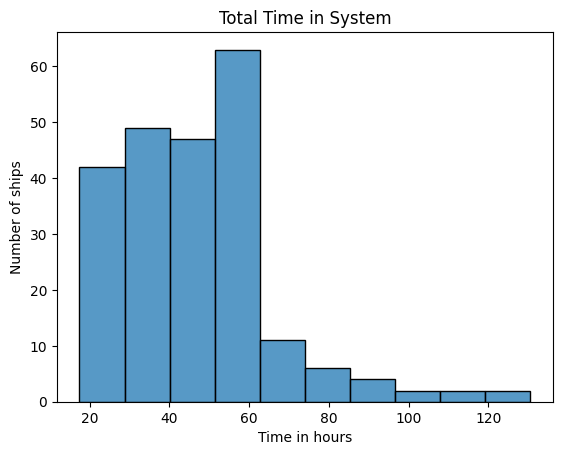

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

system_times = stats.total_times
system_times_min = [time_to_minutes(time) for time in system_times]
system_times_hours = [time / 60 for time in system_times_min]



# Plot the histogram
sns.histplot(system_times_hours, bins=10)
plt.title('Total Time in System')
plt.xlabel('Time in hours')
plt.ylabel('Number of ships')
plt.show()



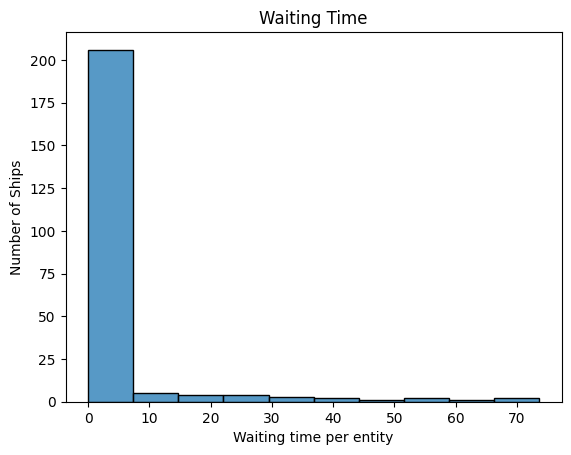

In [182]:
waiting_times = stats.waiting_times
waiting_times_min = [time_to_minutes(time) for time in waiting_times]
waiting_times_hours = [time / 60 for time in waiting_times_min]

sns.histplot(waiting_times_hours, bins=10)
plt.xlabel('Waiting time per entity')
plt.ylabel('Number of Ships')
plt.title('Waiting Time')
plt.show()


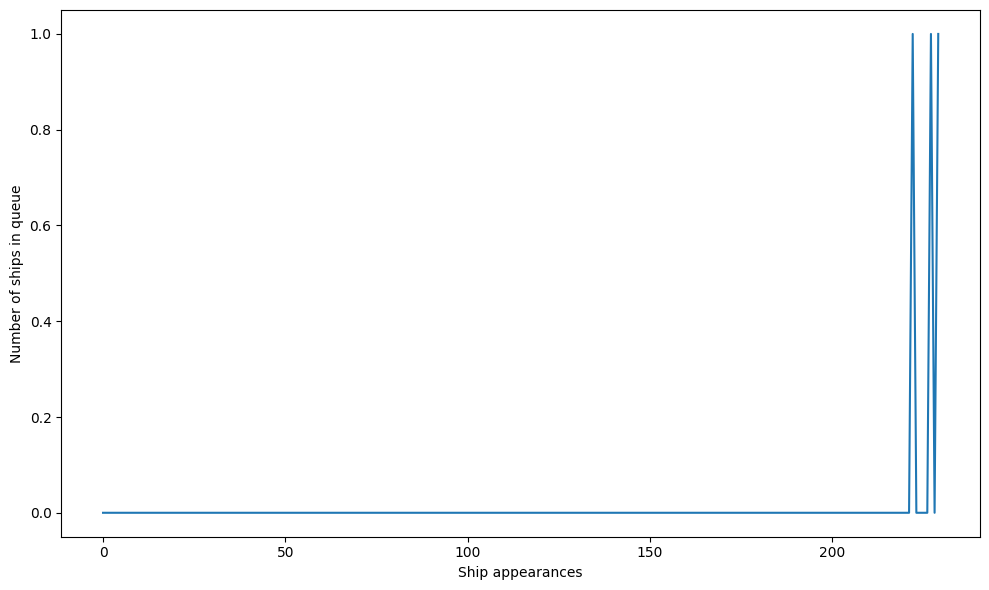

In [184]:
import matplotlib.pyplot as plt

resource_queue = stats.queue_sizes["berth"]
resource_queue1 = stats.queue_sizes["berth_type1"]
resource_queue2 = stats.queue_sizes["berth_type2"]


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.plot(range(len(resource_queue1)), resource_queue1)
plt.ylabel('Number of ships in queue')
plt.xlabel('Ship appearances')

plt.tight_layout()
plt.show()